In [13]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle
import json

import librosa
import math
import random

import hmmlearn.hmm as hmm
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

sys.path.append('..')

from preprocessing import get_mfcc

from utils import  get_all_words, get_word

import seaborn as sns
import matplotlib.pyplot as plt


# 1. Params

In [14]:
class_names = get_all_words(tiny=True)

n_state = 3
n_states = np.ones(len(class_names), dtype=int) * n_state

n_mix = 6
n_mixs = np.ones(len(class_names), dtype=int) * n_mix

k_fold = 5

In [15]:
dataset_path = '../../datasets/split'

model_path = '../../models'

# 2. Training using K-Fold cross validation

In [16]:
def load_data_kfold(dataset_path: str, class_names: list, k: int):
    """
    Chia dữ liệu thành k-fold cross-validation, mỗi fold có cấu trúc như yêu cầu.

    Args:
        dataset_path (str): Đường dẫn tới tập dữ liệu.
        class_names (list): Danh sách tên các lớp.
        k (int): Số lượng folds trong k-fold cross-validation.

    Returns:
        folds (list): Danh sách k folds, mỗi fold có dạng:
                      {'train': {'class1': [...], 'class2': [...]},
                       'test': {'class1': [...], 'class2': [...]}}.
    """
    # Tổng hợp dữ liệu và nhãn cho từng lớp
    all_data = {cname: [] for cname in class_names}

    for cname in class_names:
        file_paths = [os.path.join(dataset_path, cname, i) for i in os.listdir(
            os.path.join(dataset_path, cname)) if i.endswith('.wav')]
        
        # Tính MFCC cho mỗi file và lưu vào all_data
        all_data[cname] = [get_mfcc(file_path) for file_path in file_paths]

    # KFold cho mỗi lớp và tạo danh sách các fold
    X_folds = []
    y_folds = []

    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Duyệt qua các fold
    for fold_idx in range(k):
        X_fold = {'train': {cname: [] for cname in class_names},
                'test': {cname: [] for cname in class_names}}
        
        y_fold = {'train': {cname: [] for cname in class_names},
                'test': {cname: [] for cname in class_names}}

        for cname in class_names:
            data = all_data[cname]
            splits = list(kf.split(data))

            train_indices, test_indices = splits[fold_idx]

            # Lưu dữ liệu huấn luyện và kiểm thử
            X_fold['train'][cname] = [data[i] for i in train_indices]
            X_fold['test'][cname] = [data[i] for i in test_indices]

            y_fold['train'][cname] = [get_word(cname)["id"] - 1] * len(train_indices)
            y_fold['test'][cname] = [get_word(cname)["id"] - 1] * len(test_indices)

        X_folds.append(X_fold)
        y_folds.append(y_fold)

    return X_folds, y_folds

In [17]:
X_folds, y_folds = load_data_kfold(dataset_path, class_names, k_fold)

In [18]:
def train(X: dict[str, dict], class_names: list[str], states: list[int], n_mixs: list[int]):
    models = {}
    likelihoods = {}

    for idx, cname in enumerate(class_names):
        start_prob = np.full(states[idx], 0.0)
        start_prob[0] = 1.0
        trans_matrix = np.full((states[idx], states[idx]), 0.0)
        p = 0.5
        np.fill_diagonal(trans_matrix, p)
        np.fill_diagonal(trans_matrix[0:, 1:], 1 - p)
        trans_matrix[-1, -1] = 1.0
        trans_matrix = trans_matrix / (states[idx])
        
        models[cname] = hmm.GMMHMM(
            n_components=states[idx],
            n_mix=n_mixs[idx],
            verbose=False,
            n_iter=300,
            startprob_prior=start_prob,
            transmat_prior=trans_matrix,
            params='stmc',
            init_params='mc',
            random_state=42
        )

        models[cname].fit(X=np.vstack(X['train'][cname]),
                                lengths=[x.shape[0] for x in X['train'][cname]])

        likelihoods[cname] = models[cname].monitor_.history

    return models, likelihoods


In [19]:
def evaluation(model: dict, X: dict[str, dict], y: dict[str, dict], class_names: list[str]):
    y_true = []
    y_pred = []

    # Duyệt qua từng lớp
    for cname in class_names:
        true_for_class = []
        pred_for_class = []

        # Duyệt qua từng mẫu của lớp
        for mfcc, target in zip(X['test'][cname], y['test'][cname]):
            try:
                # Tính điểm số cho mỗi lớp
                scores = [model[c].score(mfcc) for c in class_names]
                pred = np.argmax(scores)

                # Lưu kết quả dự đoán và nhãn thực tế
                true_for_class.append(target)
                pred_for_class.append(pred)
            except Exception as e:
                print(f"Error processing sample for class {cname}: {e}")

        # Cập nhật vào danh sách chung
        y_true.extend(true_for_class)
        y_pred.extend(pred_for_class)

    return y_true, y_pred

In [20]:
all_y_true = []
all_y_pred = []

for i in tqdm(range(k_fold), desc='Training', position=0):
    # Huấn luyện mô hình cho từng fold
    models, likelihoods = train(X_folds[i], class_names, n_states, n_mixs)

    # Đánh giá mô hình
    y_true, y_pred = evaluation(models, X_folds[i], y_folds[i], class_names)
    
    # Tổng hợp nhãn dự đoán và thực tế
    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)
    
    # Accuracy cho fold hiện tại
    fold_acc = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)

Training: 100%|██████████| 5/5 [20:19<00:00, 243.88s/it]


Overall Accuracy: 0.74
Macro F1-Score: 0.75
Micro F1-Score: 0.74

Classification Report:
              precision    recall  f1-score   support

         chu       0.89      0.85      0.87        20
          ve       0.70      0.70      0.70        20
         vao       0.76      0.80      0.78        20
         tai       0.88      0.70      0.78        20
         dau       0.72      0.65      0.68        20
        cuoi       0.82      0.90      0.86        20
          ke       0.61      0.58      0.59        19
       truoc       0.31      0.79      0.45        19
        dung       0.63      0.85      0.72        20
       ngung       0.85      0.85      0.85        20
         doc       0.55      0.85      0.67        20
        tiep       0.69      0.90      0.78        20
         lui       0.77      0.85      0.81        20
         toi       0.86      0.60      0.71        20
        tang       0.93      0.65      0.76        20
          to       0.65      0.55      0.59   

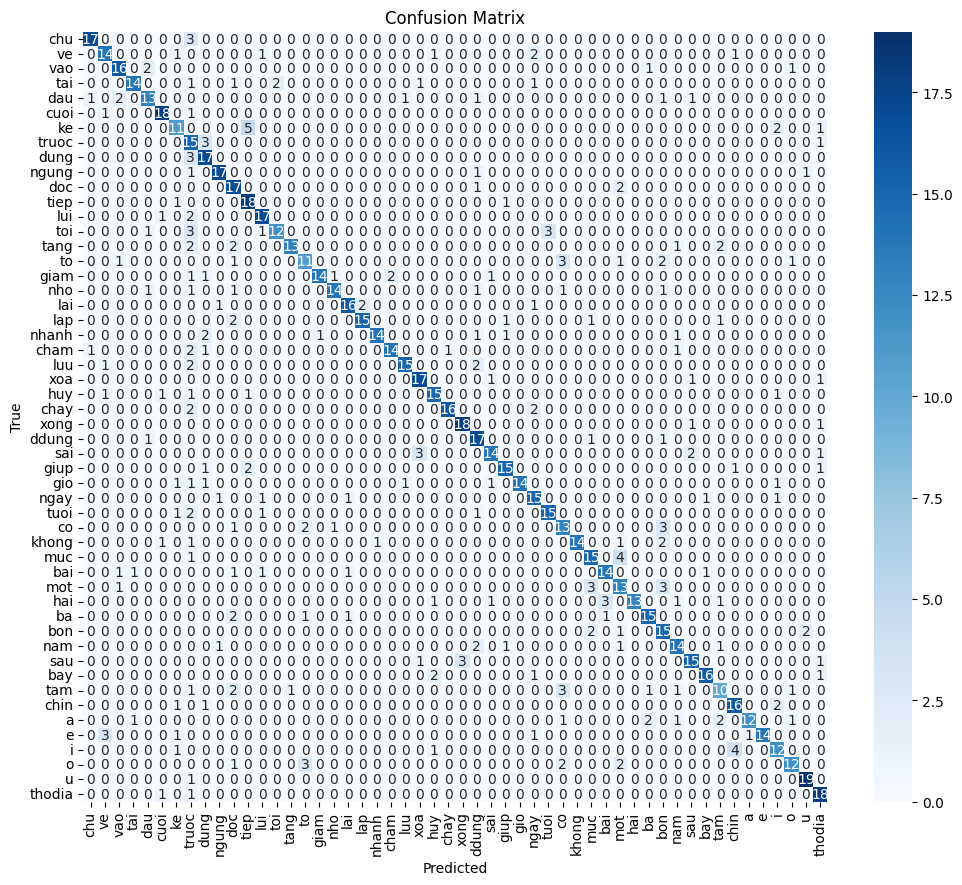

In [21]:
# Giả định các biến all_y_true, all_y_pred đã được tổng hợp qua các fold
# Tính Accuracy tổng thể
overall_accuracy = accuracy_score(all_y_true, all_y_pred)

# Tính F1-Score tổng thể (macro trung bình và micro trung bình)
f1_macro = f1_score(all_y_true, all_y_pred, average='macro')
f1_micro = f1_score(all_y_true, all_y_pred, average='micro')

# Hiển thị kết quả
print(f"Overall Accuracy: {overall_accuracy:.2f}")
print(f"Macro F1-Score: {f1_macro:.2f}")
print(f"Micro F1-Score: {f1_micro:.2f}")

# Báo cáo chi tiết từng lớp
print("\nClassification Report:")
print(classification_report(all_y_true, all_y_pred, target_names=class_names))

# Vẽ lại ma trận nhầm lẫn (nếu cần thiết)
plt.figure(figsize=(12, 10))
cm = confusion_matrix(all_y_true, all_y_pred, labels=range(len(class_names)))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 3. Final training

In [ ]:
def merge_test_to_train(folds):
    for fold in folds:
        # Duyệt qua từng class trong 'test'
        for class_name, test_data in fold['test'].items():
            # Gộp dữ liệu test vào train
            if class_name in fold['train']:
                fold['train'][class_name].extend(test_data)
            else:
                fold['train'][class_name] = test_data
        # Xóa dữ liệu trong test (nếu không cần)
        fold['test'] = {}
    return folds

In [36]:
X_final_train = merge_test_to_train(X_folds)[0]
y_final_train = merge_test_to_train(y_folds)[0]

In [38]:
models, likelihoods = train(X_final_train, class_names, n_states, n_mixs)

Model is not converging.  Current: -279930.7015419061 is not greater than -279930.42352150613. Delta is -0.2780203999718651


In [39]:
def show_prob(models: dict[str, hmm.GMMHMM], class_names: list[str]):
    for cname in class_names:
        print("\nMa trận chuyển tiếp trạng thái ẩn của \"" + cname +"\":")
        print(models[cname].transmat_)

show_prob(models, class_names)


Ma trận chuyển tiếp trạng thái ẩn của "chu":
[[0.94184102 0.01279658 0.04536239]
 [0.06708452 0.93291548 0.        ]
 [0.00351468 0.00465145 0.99183387]]

Ma trận chuyển tiếp trạng thái ẩn của "ve":
[[0.98785909 0.01214091 0.        ]
 [0.05318761 0.90705147 0.03976092]
 [0.         0.04053693 0.95946307]]

Ma trận chuyển tiếp trạng thái ẩn của "vao":
[[0.9540639  0.         0.0459361 ]
 [0.         0.99074364 0.00925636]
 [0.02914022 0.03222839 0.93863139]]

Ma trận chuyển tiếp trạng thái ẩn của "tai":
[[0.99015712 0.         0.00984288]
 [0.         0.93352726 0.06647274]
 [0.0395631  0.04650485 0.91393205]]

Ma trận chuyển tiếp trạng thái ẩn của "dau":
[[0.99142253 0.         0.00857747]
 [0.         0.94548046 0.05451954]
 [0.03566582 0.03496105 0.92937313]]

Ma trận chuyển tiếp trạng thái ẩn của "cuoi":
[[0.99048065 0.         0.00951935]
 [0.         0.88500271 0.11499729]
 [0.04251029 0.07184776 0.88564196]]

Ma trận chuyển tiếp trạng thái ẩn của "ke":
[[0.90316441 0.05177709 0

In [44]:
def calculate_delta(likelihood: list[float]):
    delta = []
    for i in range(1, len(likelihood)):
        delta.append(likelihood[i] - likelihood[i - 1])
    return delta

def plot_likelihoods(likelihoods: dict[str, list[float]], class_names: list[str], save_dir: str):
    # Tạo thư mục lưu ảnh nếu chưa tồn tại
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for cname in class_names:
        # Tạo một hình mới cho mỗi class
        plt.figure(figsize=(10, 10))

        # Vẽ Log-Likelihood Change
        plt.subplot(2, 1, 1)
        plt.plot(calculate_delta(likelihoods[cname]), label=cname, color='red')
        plt.title('Log-Likelihood Change: ' + cname)
        plt.xlabel('Iteration')
        plt.ylabel('Change in negative log likelihood')
        plt.legend()

        # Vẽ Log likelihood of training data
        plt.subplot(2, 1, 2)
        plt.plot(likelihoods[cname], label=cname, color='blue')
        plt.title('Log likelihood of training data: ' + cname)
        plt.xlabel('Iteration')
        plt.ylabel('Negative log likelihood')
        plt.legend()

        # Căn chỉnh layout để không bị chồng lấp
        plt.tight_layout()

        # Lưu hình ảnh vào thư mục
        filename = f"{cname}_likelihoods.png"
        save_path = os.path.join(save_dir, filename)
        plt.savefig(save_path)
        plt.close()  # Đóng hình để giải phóng bộ nhớ

In [45]:
plot_likelihoods(likelihoods, class_names, '../../result/likelihoods_same_state')

# 4. Save models

In [46]:
def save_model(models: dict, class_names, model_path: str, model_key: str):
    print(f'Saving models to {model_path}/{model_key}')
    if not os.path.exists(f'{model_path}/{model_key}'):
            os.makedirs(f'{model_path}/{model_key}')
    for cname in class_names:
        name = f'{model_path}/{model_key}/model_{cname}.pkl'
        
        with open(name, 'wb') as file:
            pickle.dump(models[cname], file)
    print(f'Save params to {model_path}/params.json')
    with open(f'{model_path}/{model_key}/params.json', 'w') as file:
        file.write(json.dumps({
            'n_states': [int(i) for i in n_states],
            'n_mix': n_mix,
        }))

In [47]:
save_model(models, class_names, model_path, f"same_state_{n_state}_mix_{n_mix}")

Saving models to ../../models/same_state_3_mix_6
Save params to ../../models/params.json
